## Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import sklearn.datasets
import pandas as pd

## Generate Two Moons Data

In [ ]:
NUM_LABELED_DATA = 12

X, Y = sklearn.datasets.make_moons((1000,1000))
c1 = np.argwhere(Y==1).flatten()
c2 = np.argwhere(Y==0).flatten()
lab1 = np.random.choice(len(c1), size=NUM_LABELED_DATA//2, replace=False)
lab2 = np.random.choice(len(c2), size=NUM_LABELED_DATA//2, replace=False)
lab =  np.concatenate((c1[lab1], c2[lab2]), axis=0)

# Hard Labels
'''
min_idx1 = np.argwhere(np.logical_and(X[:,0] == 1.0, Y==0))
mid_idx1 = np.argmin(X[:,1])
max_idx1 = np.argmax(X[:,0])

min_idx2 = np.argmin(X[:,0])
mid_idx2 = np.argmax(X[:,1])
max_idx2 = np.argwhere(np.logical_and(X[:,0] == 0.0, Y==1))

lab = np.array([min_idx1.item(), mid_idx1, max_idx1, min_idx2, mid_idx2, max_idx2.item()])
'''

mask = np.ones(Y.size, dtype=bool)
mask[lab] = False

X_l, Y_l = X[lab], Y[lab] # Labeled Data
X_u = X[mask] # Unlabeled Data

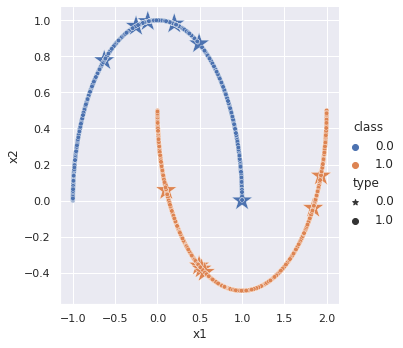

In [ ]:
sns.set_theme()

# Plot the two moons data. Stars represent labeled data.
marker_size = np.ones_like(mask, dtype=np.int)
marker_size[mask] = 20
marker_size[mask == False] = 500

df = pd.DataFrame(np.concatenate((X,Y.reshape(-1,1), mask.reshape(-1,1)), axis=1), columns = ['x1','x2', 'class', 'type'])

markers = {True: "o", False: "*"}
sns.relplot(
    data=df,
    x="x1", y="x2", hue="class", s=marker_size,
    style='type', markers=markers,
)

In [ ]:
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, u_data, l_data, transforms=None):
        super(TwoMoons, self).__init__()
        
        self.u_data = u_data
        self.l_data = l_data
        self.transforms = transforms


    def __len__(self):
        # return the number of sequences in the dataset
        return len(self.u_data)
        
    def __getitem__(self, idx):
        i = np.random.choice(12, size=1)
        x_u = torch.from_numpy(self.u_data[idx]).float()
        x_l = torch.from_numpy(self.l_data[0][i].reshape(1,-1)).float()
        y_l = torch.tensor(self.l_data[1][i].reshape(1,-1)).float()
        return x_u, (x_l, y_l)

In [ ]:
BATCH_SIZE = 64
train_dataset = TwoMoons(X_u, (X_l, Y_l))
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Define Model

In [ ]:
class SmallMLP(nn.Module):
    def __init__(self):
        super(SmallMLP, self).__init__()
        self.hidden1 = nn.Linear(2, 8)
        self.hidden2 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 1)

        self.a = nn.Sigmoid()

    def forward(self, x):
        x = self.a(self.hidden1(x))
        x = self.a(self.hidden2(x))
        out  =  self.a(self.output(x))
        return out

## Training

### Helper functions

In [ ]:
def get_flatten_params(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    #params = torch.cat(params)
    return params

def get_flatten_grads(model):
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1).detach().clone())
    #grads = torch.cat(grads)
    return grads


In [ ]:
EPOCHS = 300
lr = 0.1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)

teacher = SmallMLP().to(device)
student = SmallMLP().to(device)

optim = torch.optim.Adam(student.parameters(), lr=lr)

# Teacher pre-training on labeled data
x = torch.from_numpy(X_l).float().to(device)
y = torch.from_numpy(Y_l).reshape(-1,1).float().to(device)
for epoch in range(10):
    t_optim = torch.optim.Adam(teacher.parameters(), lr=lr)
    pred = teacher(x)
    loss = F.binary_cross_entropy(pred, y)
    if (epoch + 1) %  20 == 0:
        print(loss)
    t_optim.zero_grad()
    loss.backward()
    t_optim.step()

print(Y_l)
print(teacher(x))

step = 0
for epoch in range(EPOCHS):
    for idx, (x_u, (x_l, y_l)) in enumerate(train):
        optim.zero_grad()

        x_u = x_u.to(device)
        x_l = x_l.to(device)
        y_l = y_l.to(device)

        # Update Student with pseudo labels from the teacher
        pseudo_y = teacher(x_u).detach() # generate probability distribution parameters of labels from teacher
        pseudo_y = torch.bernoulli(pseudo_y) # sample labels from bernoulli distribution
        #pseudo_y[pseudo_y[:,0] >= 0.5] = 1
        #pseudo_y[pseudo_y[:,0] < 0.5] = 0
        output = student(x_u)

        # Compute gradient of student loss on the pseudo labels from the teacher
        stud_loss = F.binary_cross_entropy(output, pseudo_y)
        stud_loss.backward()

        # save gradient info
        student_grad = get_flatten_grads(student) # size |S|
        optim.step()


        # Now update teacher based on student performance on labeled data
        student.zero_grad()
        loss = F.binary_cross_entropy(student(x_l), y_l)
        loss.backward()

        new_student_grad = get_flatten_grads(student) # size |S|

        # compute gradient of teacher loss on pseudo labels sampled from the teacher
        teacher.zero_grad()
        loss = F.binary_cross_entropy(teacher(x_u), pseudo_y)
        loss.backward()

        teacher_grad = get_flatten_grads(teacher) # size |T|


        # compute gradient of teacher loss on labeled data
        teacher.zero_grad()
        loss = F.binary_cross_entropy(teacher(x_l), y_l)
        loss.backward()

        teacher_grad_sup = get_flatten_grads(teacher)

        with torch.no_grad():
            for i, param in enumerate(teacher.parameters()):
                # gradient of the student loss with respect to teacher parameters on the labeled dataset 
                gradient_T = lr * new_student_grad[i].reshape(1,-1) @ student_grad[i].reshape(-1,1) @ teacher_grad[i].reshape(1, -1)

                # graident of the teacher loss on the labeled dataset(i.e. gradient from regular supervised learning loss)
                gradient_sup = teacher_grad_sup[i]

                # update the teacher parameters using both gradients
                new_param = param - lr * (gradient_T.reshape(param.shape) + gradient_sup.reshape(param.shape))
                param.copy_(new_param)

        if step % 100 == 0:
            print('Step:', step)
            print('Loss:', stud_loss.item())

        step += 1

In [ ]:
# Supervised training of the teacher just on labeled data for comparison
supervised_teacher = SmallMLP().to(device)

x = torch.from_numpy(X_l).float().to(device)
y = torch.from_numpy(Y_l).reshape(-1,1).float().to(device)
for epoch in range(300):
    t_optim = torch.optim.Adam(supervised_teacher.parameters(), lr=lr)
    pred = supervised_teacher(x)
    loss = F.binary_cross_entropy(pred, y)
    if (epoch + 1) %  20 == 0:
        print(loss)
    t_optim.zero_grad()
    loss.backward()
    t_optim.step()

## Evaluation

In [ ]:
def plot_model_pred(model):
    preds = model(torch.from_numpy(X).float()).detach().numpy()

    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    marker_size = np.ones_like(mask, dtype=np.int)
    marker_size[mask] = 20
    marker_size[mask == False] = 500
    df = pd.DataFrame(np.concatenate((X,preds,mask.reshape(-1,1)), axis=1), columns = ['x1','x2', 'class', 'type'])

    markers = {True: "o", False: "*"}
    sns.relplot(
        data=df,
        x="x1", y="x2", hue="class", s=marker_size,
        style='type', markers=markers,
    )

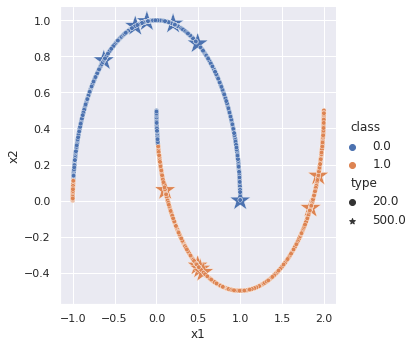

In [ ]:
plot_model_pred(student)

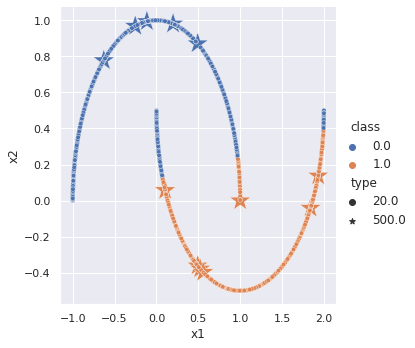

In [ ]:
plot_model_pred(teacher)

## Visualize Decision Boundary

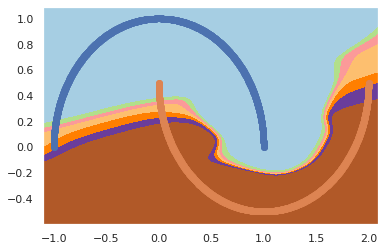

In [ ]:
# define bounds of the domain
min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.01)
x2grid = np.arange(min2, max2, 0.01)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = student(torch.from_numpy(grid).float())

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

import matplotlib.pyplot as plt
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz.detach().numpy(), cmap='Paired')

# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(Y == class_value)

    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')